In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import typing as t


In [2]:
words = open('names.txt', 'r').read().splitlines()


In [3]:
gpu = torch.device('cuda:0')

# Info and constants


In [4]:
shortestWord = min(len(w) for w in words)
longestWord = max(len(w) for w in words)
amountOfCharacters = len(set(''.join(words)))

In [5]:
START = '<S>'
"""The start token."""
END = '<E>'
"""The end token."""
TENSOR_LENGTH = amountOfCharacters + 2
"""The amount of characters in the dataset, plus 2 for the start and end tokens."""


'The amount of characters in the dataset, plus 2 for the start and end tokens.'

## Functions


In [6]:
def percentage(number: t.Union[float, int]) -> str:
    """Calculate the human-readable percentage of a number."""
    assert number >= 0, "Number must be positive"

    if number > 1:
        return f"{number:.0f}%"

    return f"{number * 100:.0f}%"

In [7]:
def iterate(words: list[str] = words) -> t.Generator[t.Tuple[str, str], None, None]:
    """Iterates over the words in the dataset, yielding the character pairs in each word."""
    for w in words:
        word = [START] + list(w) + [END]
        for ch1, ch2 in zip(word, word[1:]):
            yield ch1, ch2

# Char <-> index maps


In [8]:
chars = sorted(list(set(''.join(words))))

charToIndex = {char: index + 2 for index, char in enumerate(chars)}

charToIndex[START] = 0
charToIndex[END] = 1

In [9]:
indexToChar = {index: char for char, index in charToIndex.items()}

# Tensor


In [10]:
N = torch.zeros((TENSOR_LENGTH, TENSOR_LENGTH), dtype=torch.int32)

for ch1, ch2 in iterate():
    N[charToIndex[ch1], charToIndex[ch2]] += 1

N2 = (N + 1).float() / N.sum(1, keepdim=True)
"""Tensor with normalized, percentage values. `N2[i, j]` is the probability of character j following character i. It is also "smoothed" by adding 1. This prevents 0% percentages."""

'Tensor with normalized, percentage values. `N2[i, j]` is the probability of character j following character i. It is also "smoothed" by adding 1. This prevents 0% percentages.'

## Exercising broadcasting

When using broadcasting, bugs can occur. This experiment shows that forgetting to set keepdim when it's needed can result in transparent issues.

In this example where we don't keepDim; instead of dividing [2,2] by [2,1], we'd divide [2,2] by [1,2], meaning we sum up columns instead of rows.


In [11]:
test = torch.zeros((2, 2), dtype=torch.int32)

test[0][0] = 50
test[0][1] = 50

test[1][0] = 50
test[1][1] = 100

resolvedWith = [[100, 100], [150, 150]]
resolvedWithout = [[100, 150], [100, 150]]

resultWith = test.float() / test.sum(1, keepdim=True)
resultWithout = test.float() / test.sum(1)

resultResolvedWith = test.float() / torch.tensor(resolvedWith)
resultResolvedWithout = test.float() / torch.tensor(resolvedWithout)

print('RESULTS:')
print('with:', resultWith)
print('without:', resultWithout)

print('\nRESOLED SUM:')
# This is what happens with keepdim = true.
print('with:', resolvedWith)
# This is what happens without.
print('without:', resolvedWithout)

print('\nPROOF WITH RESOLVED VALUES:')
print('with:', resultResolvedWith)
print('without:', resultResolvedWithout)

assert resultResolvedWith[0].sum() == 1
assert resultResolvedWith[1].sum() == 1
assert resultResolvedWithout[0].sum() != 1
assert resultResolvedWithout[1].sum() != 1


RESULTS:
with: tensor([[0.5000, 0.5000],
        [0.3333, 0.6667]])
without: tensor([[0.5000, 0.3333],
        [0.5000, 0.6667]])

RESOLED SUM:
with: [[100, 100], [150, 150]]
without: [[100, 150], [100, 150]]

PROOF WITH RESOLVED VALUES:
with: tensor([[0.5000, 0.5000],
        [0.3333, 0.6667]])
without: tensor([[0.5000, 0.3333],
        [0.5000, 0.6667]])


## Visualization

This is visualizing the dataset pairs and how likely they are to occur. Impossible combinations, like the END token being the first token, are omitted.


(-0.5, 73.5, 73.5, -0.5)

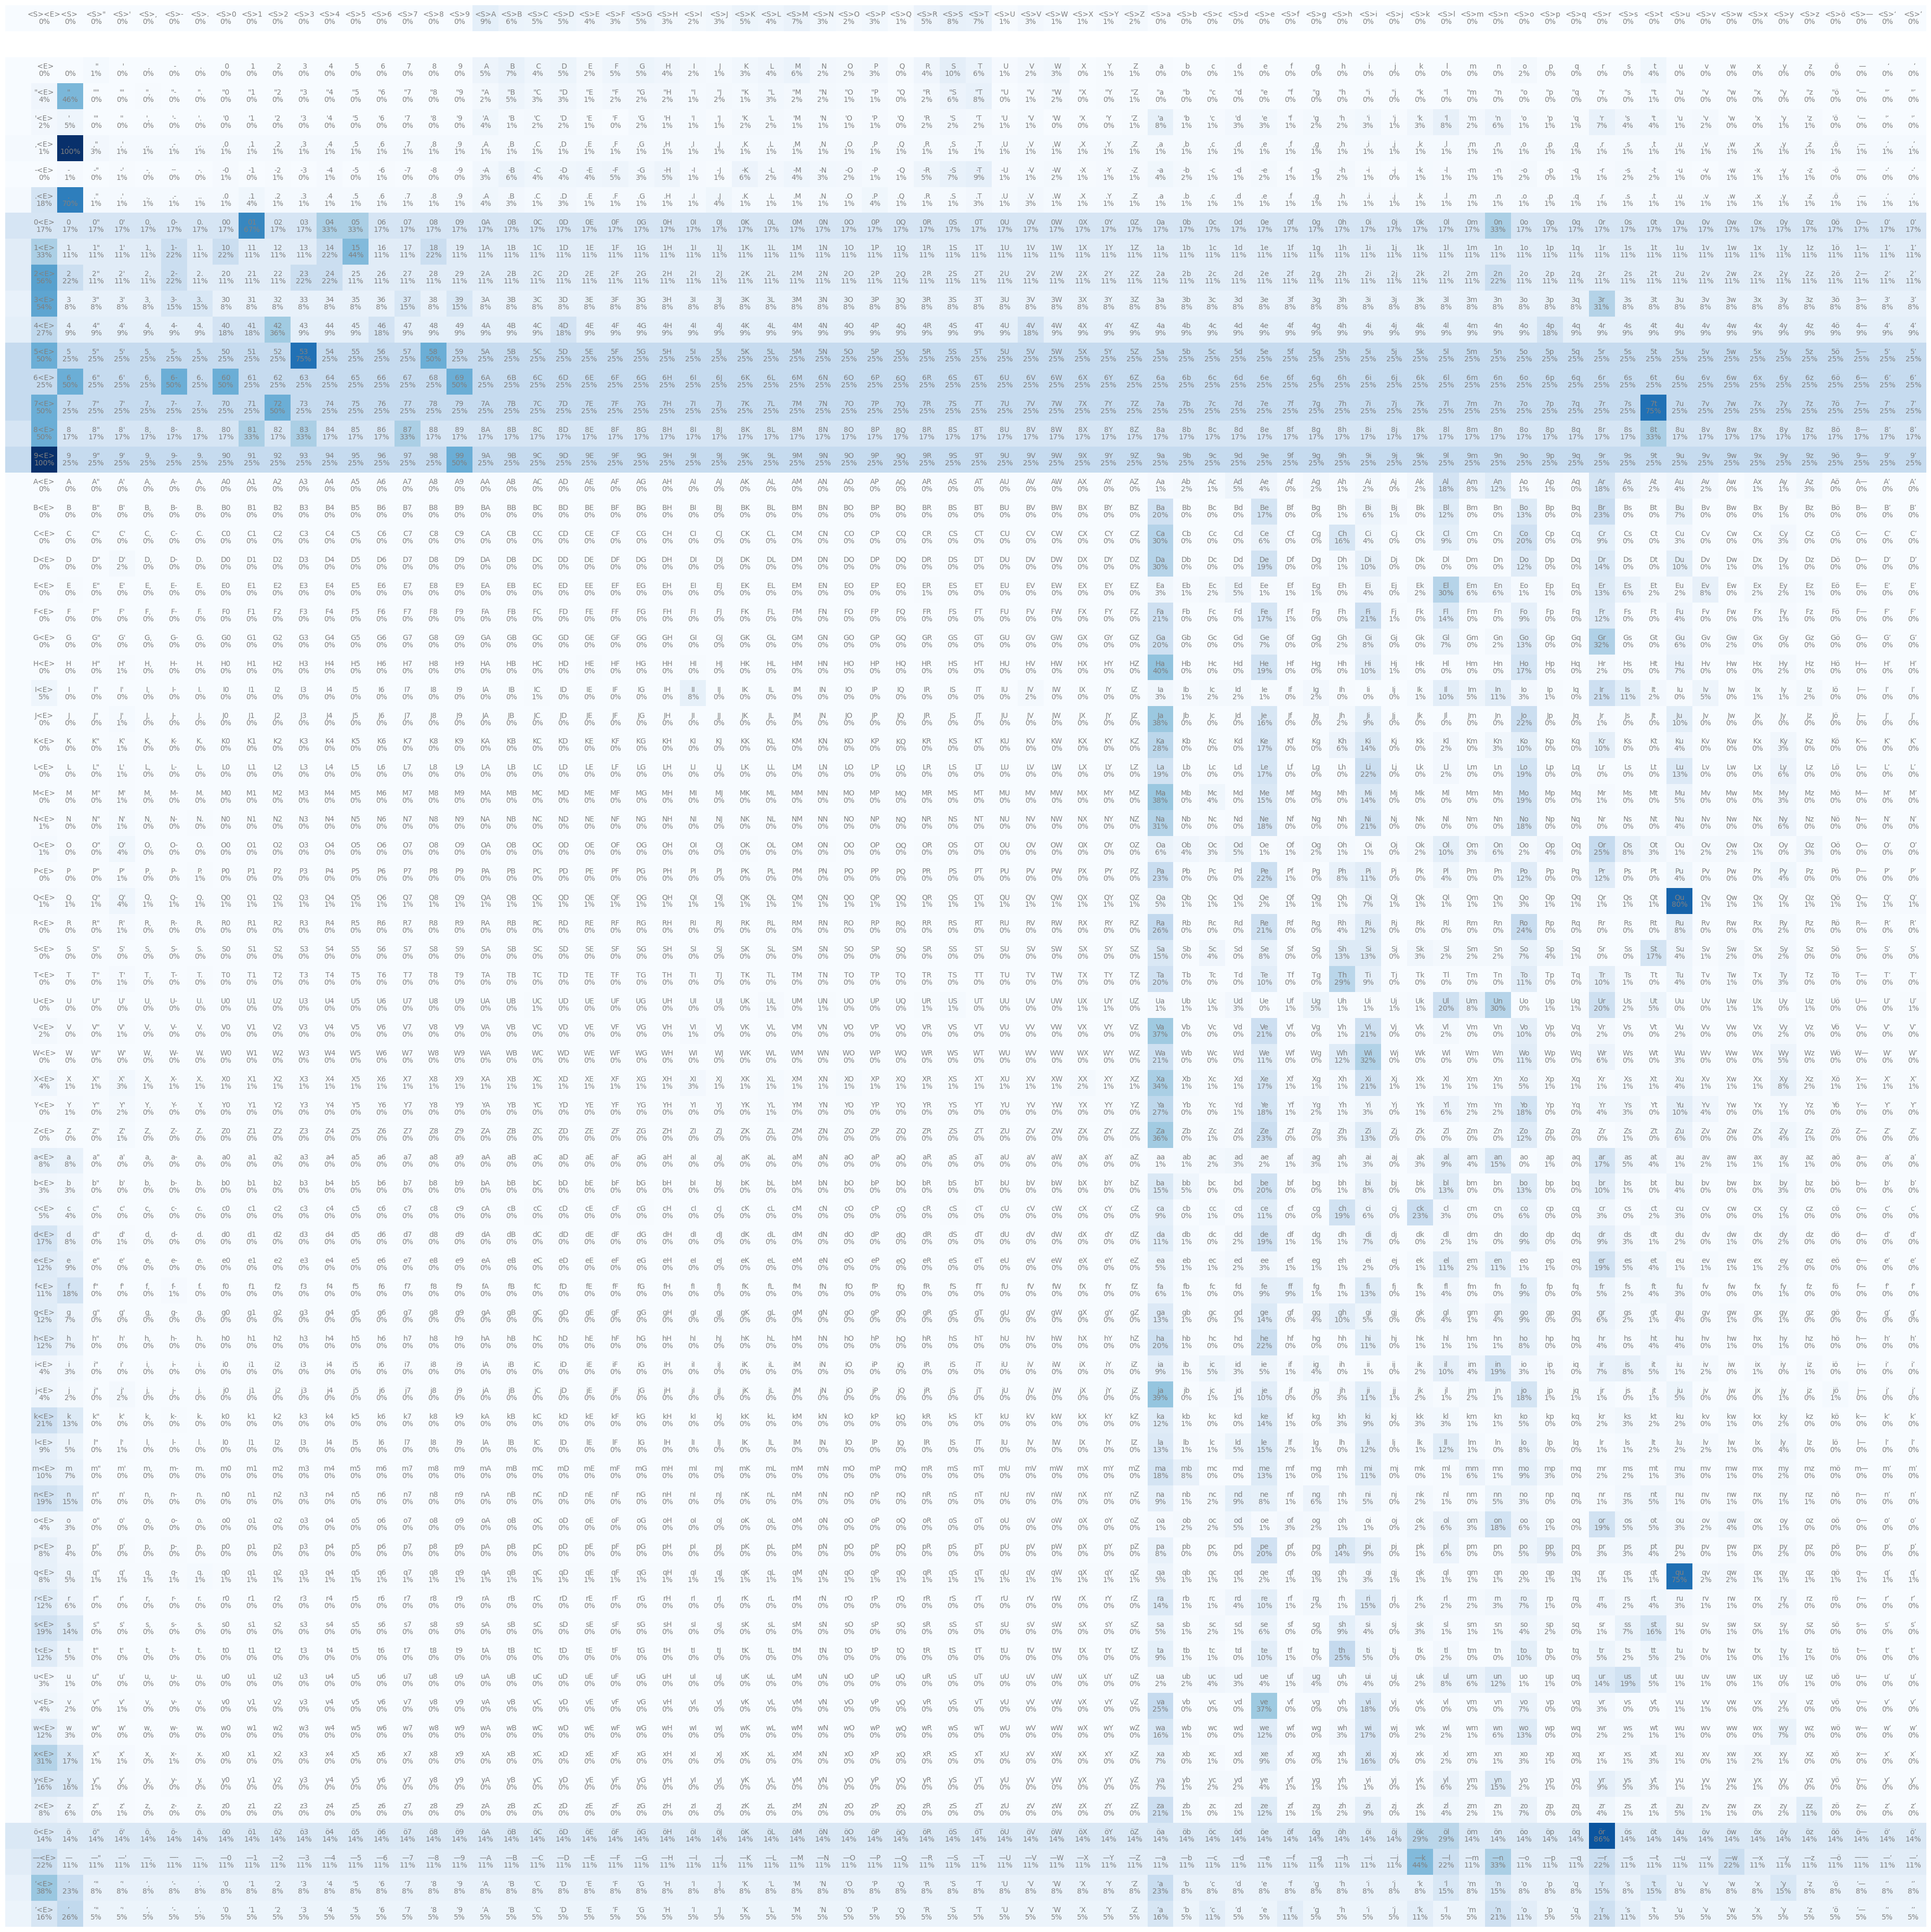

In [12]:
plt.figure(figsize=(48, 48))

tensor = N2

plt.imshow(tensor, cmap='Blues')
for i in range(tensor.shape[0]):
    for j in range(tensor.shape[1]):
        if indexToChar[i] == END:
            continue
        if indexToChar[j] == START:
            continue

        char = indexToChar[i] + indexToChar[j]
        plt.text(j, i, char, ha='center', va='bottom', color='gray')
        plt.text(j, i, percentage(N2[i, j].item()),
                 ha='center', va='top', color='gray')

plt.axis('off')


## Preparing to sample

In [13]:
# Randomly sampling from the probability matrix
generator = torch.Generator().manual_seed(2147483647)

probabilityMatrix = N[0].float()
probabilityMatrix /= probabilityMatrix.sum()
probabilityMatrix

indexToChar[torch.multinomial(
    probabilityMatrix, num_samples=1, replacement=True, generator=generator).item()]


'O'

### Checking more samples


In [14]:
generator = torch.Generator().manual_seed(2147483647)
p = torch.rand(4, generator=generator)
p /= p.sum()
p

torch.multinomial(p, num_samples=20, replacement=True, generator=generator)


tensor([3, 0, 0, 3, 3, 0, 2, 3, 2, 1, 3, 2, 3, 3, 3, 1, 0, 3, 0, 1])

## Sampling

In [15]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):

    out = []
    index = 0

    while True:
        p = N2[index]

        index = torch.multinomial(
            p, num_samples=1, replacement=True, generator=g).item()
        out.append(indexToChar[index])
        if (index == 1):
            break

    print(''.join(out))


Olad'r<E>
Tas<E>
Lan<E>
Da‘-mis<E>
Nie<E>
Patovistof<E>
Nergeriagodos<E>
Du<E>
Oa Nea<E>
Rer HosicFul Rilierittut<E>


# Log likelihood, loss function

- GOAL: Maximize likelihood of the data with model parameters (statistical modeling)

  -> Equivalent to maximizing the log likelihood (because log is monotonic)

  -> Equivalent to minimizing the negative log likelihood

  -> Equivalent to minimzing the average negative log likelihood

---

`log(a * b * c ) = log(a) + log(b) + log(c)`


In [16]:
log_likelihood = 0.0
n = 0

for ch1, ch2 in iterate(["Lynn Grey"]):
    index1 = charToIndex[ch1]
    index2 = charToIndex[ch2]
    prob = N2[index1][index2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    print(f"{ch1} -> {ch2} | {prob:.3f} | {logprob:.3f}")

print(f"Log likelihood: {log_likelihood}")
print(f"Negative log likelihood: {-log_likelihood}")
print(f"Loss: {-log_likelihood / n}")


<S> -> L | 0.045 | -3.103
L -> y | 0.058 | -2.845
y -> n | 0.148 | -1.909
n -> n | 0.054 | -2.919
n ->   | 0.153 | -1.880
  -> G | 0.051 | -2.969
G -> r | 0.319 | -1.143
r -> e | 0.098 | -2.318
e -> y | 0.018 | -4.028
y -> <E> | 0.158 | -1.844
Log likelihood: -24.95804214477539
Negative log likelihood: 24.95804214477539
Loss: 2.4958043098449707


# Approach: Neural Network


## Dataset

* `xs` = Input
* `ys` = Output

In [17]:
xs, ys = [], []

for ch1, ch2 in iterate(words[:1]):
    index1 = charToIndex[ch1]
    index2 = charToIndex[ch2]

    xs.append(index1)
    ys.append(index2)

    print(ch1, ch2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

<S> O
O i
i k
k i
i  
  H
H a
a l
l c
c y
y o
o n
n <E>


In [18]:
xs

tensor([ 0, 32, 52, 54, 52,  2, 25, 44, 55, 46, 68, 58, 57])

In [19]:
ys

tensor([32, 52, 54, 52,  2, 25, 44, 55, 46, 68, 58, 57,  1])

In [20]:
import torch.nn.functional as F

encoded = F.one_hot(xs, num_classes=TENSOR_LENGTH).float()

xs, encoded

(tensor([ 0, 32, 52, 54, 52,  2, 25, 44, 55, 46, 68, 58, 57]),
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

Here, `encoded` is the one-hot encoded input. This means that each input is represented by a vector of length `TENSOR_LENGTH` with a single `1` and the rest `0`. The value that is `1` is the index of the character in the alphabet.

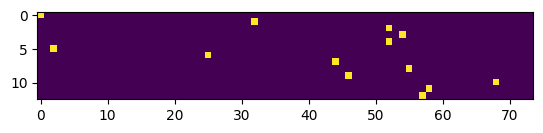

In [21]:
plt.imshow(encoded)

## Matrix multiplication

By doing `encoded @ weights`, which is matrix multiplication in Pytorch, the matrices `encoded = [13, 27]` and `weights = [27, 1]` become [13, 1] as it squeezes (?).

> Note: Not sure why that is exactly, but I assume that well, you can't multiply for example the 14th index in `weights` with zero (because 14 doesn't exist in `encoded`), as it would result in zero... so it gets discarded.

Multiplying `encoded @ weights` results in the the activation of each input by feeding it weights (inputs).. but with no bias.

These weights would usually come from the training process, but for now we'll just use random weights.

In [22]:
weights = torch.randn((TENSOR_LENGTH, 1))

encoded @ weights

tensor([[ 0.2166],
        [-0.3185],
        [ 0.5196],
        [ 0.4502],
        [ 0.5196],
        [-1.2143],
        [ 0.8835],
        [-0.8122],
        [ 0.2540],
        [-0.2050],
        [ 0.9632],
        [ 0.8894],
        [-0.4615]])

### Using `TENSOR_LENGTH` neurons

> Note: `TENSOR_LENGTH` = 72

`[13, TENSOR_LENGTH] @ [TENSOR_LENGTH, TENSOR_LENGTH]` -> `[13, TENSOR_LENGTH]`

It is now telling us what the firing rate is for every one of 72 neurons what the firing rate is for every one of the 13 examples. For example, `[3, 13]` will tell us what the firing rate is for the 13th neuron for the 3rd input.

In [23]:
weights = torch.randn((TENSOR_LENGTH, TENSOR_LENGTH), generator=generator)

print((encoded @ weights).shape)

torch.Size([13, 74])


In [24]:
print('Result of [3, 13]', (encoded @ weights)[3, 13])

Result of [3, 13] tensor(0.5248)


#### Manual example of `(encoded @ weights)[3, 13]`

In [25]:
manual = (encoded[3] * weights[:, 13]).sum()
automatic = (encoded @ weights)[3, 13]

print('Manual:', manual)
print('Using @:', automatic)
print('Is the same?', manual == automatic)

Manual: tensor(0.5248)
Using @: tensor(0.5248)
Is the same? tensor(True)


## The easiest NN

### Using exp()

We're now using `exp()` on the tensor.

Using `exp()` runs every value through an exponential function. This means that every negative number is converted to < 1 and every positive number is > 1 in an exponential fashion.

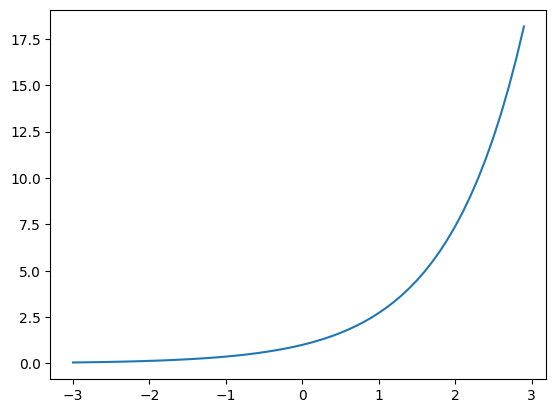

In [26]:
x = np.arange(-3, 3, 0.1)
y = np.exp(x)
plt.plot(x, y)

In [27]:
encoded @ weights

tensor([[ 8.3720e-01, -4.9714e-01, -9.3980e-01,  1.3429e-01,  5.4011e-02,
         -1.7400e+00,  1.1560e-01,  8.0319e-01,  1.0656e+00, -1.1542e-02,
          4.8346e-01, -3.1640e-01,  3.8012e-01,  4.7328e-01, -9.1027e-01,
         -7.8305e-01, -1.1582e-01, -1.2078e+00, -7.4410e-01, -5.9028e-01,
          9.3743e-01, -8.8303e-01,  1.7457e+00,  2.1346e+00,  2.5691e-01,
          2.1303e-01,  1.5514e+00, -1.3410e+00, -1.0447e+00, -6.6414e-01,
         -7.2390e-01,  1.7507e+00, -9.8378e-01, -1.5256e-01, -1.9297e+00,
         -7.8860e-02, -1.1641e+00,  1.2473e+00, -2.7061e-01, -1.3635e+00,
         -5.4209e-01, -5.9234e-01, -6.4260e-01, -1.0003e-01, -1.2575e+00,
          9.4180e-01, -1.3257e+00,  1.4670e-01,  9.4754e-02, -1.1645e+00,
          1.8010e+00,  4.7074e-01, -8.7462e-01, -2.9771e-01, -1.3707e+00,
          1.1500e-01, -1.8007e-01,  1.3034e+00, -1.1887e+00,  8.0475e-01,
         -1.7149e+00, -3.3787e-01, -1.8263e+00, -8.3897e-01,  1.3348e+00,
          4.9849e-01,  2.0722e-01, -7.

In [28]:
(encoded @ weights).exp()

tensor([[ 2.3099,  0.6083,  0.3907,  1.1437,  1.0555,  0.1755,  1.1225,  2.2327,
          2.9027,  0.9885,  1.6217,  0.7288,  1.4625,  1.6053,  0.4024,  0.4570,
          0.8906,  0.2989,  0.4752,  0.5542,  2.5534,  0.4135,  5.7299,  8.4538,
          1.2929,  1.2374,  4.7180,  0.2616,  0.3518,  0.5147,  0.4849,  5.7587,
          0.3739,  0.8585,  0.1452,  0.9242,  0.3122,  3.4809,  0.7629,  0.2558,
          0.5815,  0.5530,  0.5259,  0.9048,  0.2844,  2.5646,  0.2656,  1.1580,
          1.0994,  0.3121,  6.0554,  1.6012,  0.4170,  0.7425,  0.2539,  1.1219,
          0.8352,  3.6818,  0.3046,  2.2361,  0.1800,  0.7133,  0.1610,  0.4322,
          3.7991,  1.6462,  1.2303,  0.4554,  1.1918,  0.1013,  0.4920,  0.7461,
          0.5456,  2.5037],
        [ 1.5675,  1.3901,  0.5221,  0.3460,  1.2375,  3.1403,  4.0038,  0.2507,
          0.0342,  1.1037,  0.5700,  0.3815,  0.5982,  0.2692,  0.1353,  1.1928,
          1.7560,  1.0789,  1.0859,  2.3252,  7.8363,  0.6296,  0.5598,  1.9042,


The values are now counts. These counts can now never be 0 and are always positive numbers and now they can take on various value on the settings (`weights`). They can be interpreted as log counts. They are often called `logits` (in deep learning, the `logits` are the values that are the net inputs of the last layer of the network).

The result of exponentiating `logits` is equivalent to the `N` matrix from before.

In [29]:
logits = (encoded @ weights)
counts = logits.exp()

probability = counts / counts.sum(dim=1, keepdim=True)

probability

tensor([[0.0231, 0.0061, 0.0039, 0.0114, 0.0106, 0.0018, 0.0112, 0.0223, 0.0290,
         0.0099, 0.0162, 0.0073, 0.0146, 0.0161, 0.0040, 0.0046, 0.0089, 0.0030,
         0.0048, 0.0055, 0.0255, 0.0041, 0.0573, 0.0845, 0.0129, 0.0124, 0.0472,
         0.0026, 0.0035, 0.0051, 0.0048, 0.0576, 0.0037, 0.0086, 0.0015, 0.0092,
         0.0031, 0.0348, 0.0076, 0.0026, 0.0058, 0.0055, 0.0053, 0.0090, 0.0028,
         0.0256, 0.0027, 0.0116, 0.0110, 0.0031, 0.0605, 0.0160, 0.0042, 0.0074,
         0.0025, 0.0112, 0.0084, 0.0368, 0.0030, 0.0224, 0.0018, 0.0071, 0.0016,
         0.0043, 0.0380, 0.0165, 0.0123, 0.0046, 0.0119, 0.0010, 0.0049, 0.0075,
         0.0055, 0.0250],
        [0.0145, 0.0128, 0.0048, 0.0032, 0.0114, 0.0290, 0.0370, 0.0023, 0.0003,
         0.0102, 0.0053, 0.0035, 0.0055, 0.0025, 0.0013, 0.0110, 0.0162, 0.0100,
         0.0100, 0.0215, 0.0724, 0.0058, 0.0052, 0.0176, 0.0052, 0.0110, 0.0022,
         0.0295, 0.0050, 0.0117, 0.0115, 0.0044, 0.0488, 0.0142, 0.0207, 0.0188,
  

This process above now spits out probabilities for each character in the dataset. The `probability` variable is the same as the `N` matrix from before.

## Summary

We randomly generate 72 neurons' weights. Each neuron receives 72 inputs.

1. We encode the input `xs` using one-hot encoding.
2. We multiply this in the first layer of the neural net to get logits.
3. Exponentiate the logits to get counts.
4. Normalize the counts to get probabilities.

The last two steps are called the `softmax` function. [See image](https://miro.medium.com/v2/resize:fit:1400/1*ReYpdIZ3ZSAPb2W8cJpkBg.jpeg). In the image, `z` are logits which are exponentiated and then normalized to get probabilities, so it always sums to 1.

In [30]:
print('Input', list(map(lambda x: indexToChar[x.item()], xs)))
print('Output', list(map(lambda x: indexToChar[x.item()], ys)))

g = torch.Generator().manual_seed(2147483647)
# Now, we randomly generate 72 neurons' weights. Each neuron receives 72 inputs.
W = torch.randn((TENSOR_LENGTH, TENSOR_LENGTH), generator=g)

# <-- This is a forward pass -->
# 1. We encode the input using one-hot encoding.
encoded = F.one_hot(xs, num_classes=TENSOR_LENGTH).float()
# 2. We multiply this in the first layer of the neural net to get logits.
logits = (encoded @ W)
# 3. Exponentiate the logits to get counts.
counts = logits.exp()
# 4. Normalize the counts to get probabilities.
probs = counts / counts.sum(dim=1, keepdim=True)
# The last two lines are called a `softmax`.

Input ['<S>', 'O', 'i', 'k', 'i', ' ', 'H', 'a', 'l', 'c', 'y', 'o', 'n']
Output ['O', 'i', 'k', 'i', ' ', 'H', 'a', 'l', 'c', 'y', 'o', 'n', '<E>']


A loop through the first word as an input.

In [31]:
nlls = torch.zeros(len(ys))
# iterate over xs and output indexToChar for every item in xs
print('Input:', list(map(lambda x: indexToChar[x.item()], xs)))
print('Output:', list(map(lambda x: indexToChar[x.item()], ys)))

for i in range(len(nlls)):
    x = xs[i].item()
    y = ys[i].item()
    # i-th bigram:
    print('--------')
    print(f'Loop: {i + 1}')
    print(f'Bigram: "{indexToChar[x]}{indexToChar[y]}" [{x},{y}]')
    print('Input:', x, f'("{indexToChar[x]}")')
    print('Output probabilities:\n', probs[i])
    print('Predicted next character:', probs[i].argmax().item(), f'("{indexToChar[probs[i].argmax().item()]}")')
    print('Actual next character:', y, f'("{indexToChar[y]}")')
    p = probs[i, y]
    print('Probability assigned to the correct character:', p.item(), f'({p.item() * 100:.2f}%)')
    logp = torch.log(p)
    print('Log likelihood:', logp.item())
    nll = -logp
    print('Negative log likelihood:', nll.item())
    nlls[i] = nll

print('=========')
print('Average negative log likelihood, i.e. loss =', nlls.mean().item())

Input: ['<S>', 'O', 'i', 'k', 'i', ' ', 'H', 'a', 'l', 'c', 'y', 'o', 'n']
Output: ['O', 'i', 'k', 'i', ' ', 'H', 'a', 'l', 'c', 'y', 'o', 'n', '<E>']
--------
Loop: 1
Bigram: "<S>O" [0,32]
Input: 0 ("<S>")
Output probabilities:
 tensor([0.0325, 0.0053, 0.0066, 0.0023, 0.0090, 0.0066, 0.0014, 0.0124, 0.0073,
        0.0167, 0.0042, 0.0149, 0.0049, 0.0044, 0.0267, 0.1272, 0.0323, 0.0013,
        0.0133, 0.0029, 0.0181, 0.0058, 0.0015, 0.0106, 0.0063, 0.0822, 0.0780,
        0.0035, 0.0020, 0.0092, 0.0023, 0.0140, 0.0071, 0.0251, 0.0030, 0.0029,
        0.0011, 0.0237, 0.0020, 0.0228, 0.0026, 0.0054, 0.0048, 0.0094, 0.0018,
        0.0208, 0.0123, 0.0107, 0.0071, 0.0012, 0.0076, 0.0151, 0.0116, 0.0021,
        0.0078, 0.0025, 0.0099, 0.0109, 0.0027, 0.0031, 0.0077, 0.0055, 0.0024,
        0.0015, 0.0173, 0.0028, 0.0388, 0.0572, 0.0029, 0.0116, 0.0125, 0.0308,
        0.0024, 0.0035])
Predicted next character: 15 ("7")
Actual next character: 32 ("O")
Probability assigned to the correct ch

## Optimizing loss

In [32]:
# Random initialization of weights
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((TENSOR_LENGTH, TENSOR_LENGTH), requires_grad=True, generator=g)

In [33]:
# Forward pass
encoded = F.one_hot(xs, num_classes=TENSOR_LENGTH).float()
logits = (encoded @ W)
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdims=True)
loss = -probs[torch.arange(len(ys)), ys].log().mean()

loss.item()

5.234116077423096

### Backpropagation

In [34]:
W.grad = None
loss.backward()

In [35]:
W.data -= 0.1 * W.grad

### Loop

In [36]:
from typing import Tuple

def generate_dataset(_from: int = 0, _to: int = len(words)) -> Tuple[torch.Tensor, torch.Tensor]:
    xs, ys = [], []
    for w in words[_from:_to]:
        chs = [START] + list(w) + [END]

        for ch1, ch2 in zip(chs, chs[1:]):
            xs.append(charToIndex[ch1])
            ys.append(charToIndex[ch2])

    return torch.tensor(xs), torch.tensor(ys)

In [37]:

g = torch.Generator(gpu).manual_seed(2147483647)
# W = torch.randn((TENSOR_LENGTH, TENSOR_LENGTH), requires_grad=True, generator=g)
W = torch.load('weights_loss-2.6.pt')

In [38]:
xs, ys = generate_dataset()

### Gradient descent

In [39]:
for i in range(1):
    # Forward pass
    encoded = F.one_hot(xs, num_classes=TENSOR_LENGTH).float().to(gpu)
    logits = (encoded.to(gpu) @ W.to(gpu))
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdims=True)
    loss = -probs[torch.arange(len(ys)), ys].log().mean() + 0.01 * (W**2).mean()

    # Backpropagation
    W.grad = None
    loss.backward()

    # Update weights
    W.data -= 50 * W.grad

    print(f'Loss {i}:', loss.item())

Loss 0: 2.7199289798736572


### Sampling

In [47]:

for i in range(10):
    out = []
    index = 0

    while True:
        encoded = F.one_hot(torch.tensor([index]), num_classes=TENSOR_LENGTH).float().to(gpu)
        logits = (encoded.to(gpu) @ W.to(gpu))
        counts = logits.exp()
        p = counts / counts.sum(dim=1, keepdims=True)

        index = torch.multinomial(
            p, num_samples=1, replacement=True, generator=g).item()

        out.append(indexToChar[index])

        if (index == 1):
            break

    print(''.join(out))


War<E>
Tha<E>
Py Sthronk Palledafopr<E>
Pibevilk<E>
CawBolyathteponarmee<E>
Mas<E>
Yu<E>
Zaiton Flonwonshol Alda<E>
Ti<E>
Manser<E>
